In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys

# Change directory to parent directory
os.chdir('..')
# Add current directory to path
sys.path.insert(0, os.getcwd())
print(f"Working directory changed to: {os.getcwd()}")


Working directory changed to: w:\piano-ai\VQPiano


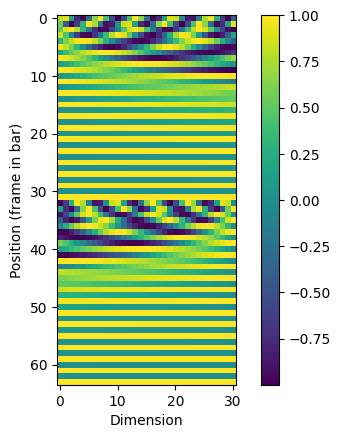

In [26]:
import torch
from segment_full_song.models.pe import StartEndPosEmb, binary_positional_encoding, one_hot_positional_encoding
import matplotlib.pyplot as plt

pe = StartEndPosEmb(32, 64).forward(torch.tensor([0]),torch.tensor([32]),torch.arange(1,32).unsqueeze(0))

plt.imshow(pe[0].T)
plt.xlabel('Dimension')
plt.ylabel('Position (frame in bar)')
plt.colorbar()
plt.show()

torch.Size([32, 5])
torch.Size([32, 32])


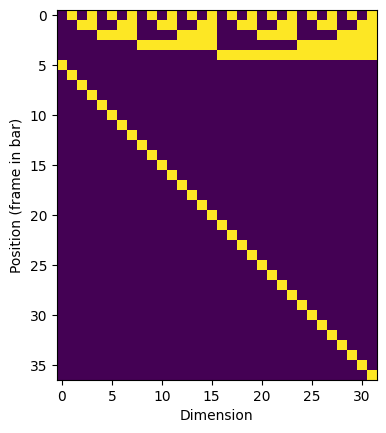

In [23]:
import torch
from segment_full_song.models.pe import binary_positional_encoding, one_hot_positional_encoding
import matplotlib.pyplot as plt

binary_pe = binary_positional_encoding(32, 5)
one_hot_pe = one_hot_positional_encoding(32, 32)

print(binary_pe.shape)
print(one_hot_pe.shape)

plt.imshow(torch.cat([binary_pe, one_hot_pe], dim=1).T)
plt.xlabel('Dimension')
plt.ylabel('Position (frame in bar)')
plt.show()

In [3]:
import json

song_list = json.load(open(r'eval_results\song_list\user_study.json'))
l = 0
for song in song_list[1:]:
    for seg in song['segmentation']:
        l += seg['end'] - seg['start']
print(l)

2363


In [ ]:
from omegaconf import OmegaConf
from segment_full_song.data.factory import create_dataloader


train, test = create_dataloader(OmegaConf.load("config/dataset/segment_full_song.yaml"),{},OmegaConf.load("config/model/segment_full_song.yaml"))

In [ ]:
from pathlib import Path
from music_data_analysis import Pianoroll


Pianoroll.from_midi(Path("dataset/pop80k_k/synced_midi/@SangeoMusic/0Zo2uPKfzvg/3438_3730.mid")).duration

In [ ]:
print(train.dataset.ds.get_song("@SangeoMusic/0Zo2uPKfzvg/3438_3730").read_json("duration") // 256)

In [ ]:
s = train.dataset.songs[19456]
s.read_midi("synced_midi").dump("f.mid")
s.song_name

In [ ]:
a = train.dataset[19456]
while a['target']['pianoroll'].metadata.end_time//32 < 38:
    a = train.dataset[19456]
a

In [ ]:
a['target']['tokens'].to_pianoroll().to_midi("b.mid")
# a['target']['pianoroll'].notes

In [ ]:
from matplotlib import pyplot as plt


accum = [0]*57
for i in range(300):
    a = train.dataset[0]
    start, end = (a['target']['pianoroll'].metadata.start_time//32, a['target']['pianoroll'].metadata.end_time//32)
    for i in range(start, end):
        accum[i] += 1
accum
plt.bar(range(57),accum)


In [ ]:
a["target"]["pianoroll"].to_midi("test.mid")

In [ ]:
from pathlib import Path
from music_data_analysis import Pianoroll
from segment_full_song.models.token_sequence import TokenSequence


# pr1 = Pianoroll(
#     [
#         Note(onset=0, pitch=60, velocity=100, offset=3),
#         Note(onset=3, pitch=60, velocity=100, offset=6),
#         Note(onset=3, pitch=62, velocity=100, offset=5),
#         Note(onset=6, pitch=60, velocity=100, offset=7),
#         Note(onset=6, pitch=62, velocity=100, offset=8),
#         Note(onset=31, pitch=60, velocity=100, offset=64),
#         Note(onset=31, pitch=50, velocity=100, offset=33),
#         Note(onset=33, pitch=50, velocity=100, offset=64),
#     ],
#     duration=64,
# )
# pr1 = Pianoroll.load(
#     Path(
#         "/mnt/gestalt/home/eri24816/segment-full-song-gen/dataset/pop80k_k/pianoroll/@SangeoMusic/0Zo2uPKfzvg/3438_3730.pt"
#     )
# )
pr1 = Pianoroll.from_midi(
    Path(
        "/mnt/gestalt/home/eri24816/segment-full-song-gen/dataset/pop80k_k/synced_midi/@SangeoMusic/0Zo2uPKfzvg/3438_3730.mid"
    )
)
pr1.to_midi("test.mid")

In [ ]:
for note in pr1.notes:
    if note.offset - note.onset > 63:
        note.offset = note.onset + 63

def check_note_equal(pr1, pr2):
    for note1, note2 in zip(pr1, pr2):
        try:
            assert note1.onset == note2.onset
            assert note1.pitch == note2.pitch
            assert note1.velocity == note2.velocity
            assert note1.offset == note2.offset
        except AssertionError:
            print(note1, note2)
            raise AssertionError
TokenSequence.from_pianorolls([pr1], max_note_duration=63, need_frame_tokens=True).to_pianoroll().to_midi("test2.mid")
print(
    TokenSequence.from_pianorolls([pr1], max_note_duration=63, need_frame_tokens=False)
)
print(
    TokenSequence.from_pianorolls([pr1], max_note_duration=63, need_frame_tokens=False)
    .to_pianoroll()
    .notes
)
check_note_equal (
    TokenSequence.from_pianorolls([pr1], max_note_duration=63, need_frame_tokens=False)
    .to_pianoroll()
    .notes
    , pr1.notes
)
check_note_equal (
    TokenSequence.from_pianorolls([pr1], max_note_duration=63, need_frame_tokens=True)
    .to_pianoroll()
    .notes
    , pr1.notes
)
check_note_equal (
    TokenSequence.from_pianorolls(
        [pr1], max_note_duration=63, need_frame_tokens=True, need_end_token=True
    )
    .to_pianoroll()
    .notes
    , pr1.notes
)


In [ ]:

TokenSequence.from_pianorolls(
    [pr1], max_note_duration=64, need_frame_tokens=True
).to_pianoroll().to_midi("test2.midi")


In [29]:
import numpy as np
import random
from typing import TypedDict
def get_compose_order(segments: list[dict]):
    # simulate that human make this music.

    # First, the composer comes up with the seed segment (possibly chorus).
    # To identify the seed segment, the model looks for the segment label with most bars in total.
    # Within segments with this label, it selects the segment that is clost to the middle of the song.
    import random

    duration = max(segment["end"] for segment in segments)
    segment_compose_order = []

    n_bars_per_label = [0] * (max(segment["label"] for segment in segments) + 1)
    for i in range(len(segments)):
        n_bars_per_label[segments[i]["label"]] += (
            segments[i]["end"] - segments[i]["start"]
        ) // 32

    # print("n_bars_per_label", n_bars_per_label)

    label_sorted_by_n_bars = np.argsort(n_bars_per_label)

    # The composer writes a segment with the most common label first.
    label = label_sorted_by_n_bars[-1]
    selected_segment = None
    for segment in segments:
        if segment["label"] == label:
            if selected_segment is None:
                selected_segment = segment
            elif abs(segment["start"] - duration // 2) < abs(
                selected_segment["start"] - duration // 2
            ):
                selected_segment = segment
    segment_compose_order.append(selected_segment)

    # Next, the composer writes a segment with the second most common label.
    if len(n_bars_per_label) > 2:
        label = label_sorted_by_n_bars[-2]
        selected_segment = None
        for segment in segments:
            if segment["label"] == label:
                if selected_segment is None:
                    selected_segment = segment
                elif abs(segment["start"] - duration // 2) < abs(
                    selected_segment["start"] - duration // 2
                ):
                    selected_segment = segment
        segment_compose_order.append(selected_segment)


    # randomly permute the remaining segments
    remaining_segments = [
        segment for segment in segments if segment not in segment_compose_order
    ]
    random.shuffle(remaining_segments)

    segment_compose_order.extend(remaining_segments)

    # print("segment_compose_order", segment_compose_order)

    return segment_compose_order



class SampleTrainingSegmentsResultItem(TypedDict):
    start: int
    end: int
    shift_from_segment_start: int
    segment_duration: int
    label: int


def get_context_for_target_segment(
    segments: list[dict],
    target_segment: dict,
) -> dict[str, SampleTrainingSegmentsResultItem]:
    target_index = segments.index(target_segment)
    already_composed_segments = segments[:target_index]

    nearest_left_segment = None
    nearest_left_segment_distance = float("inf")
    for segment in reversed(already_composed_segments):
        if segment["end"] > target_segment["start"]:
            continue
        left_segment_distance = target_segment["start"] - segment["end"]
        if left_segment_distance < nearest_left_segment_distance:
            nearest_left_segment_distance = left_segment_distance
            nearest_left_segment = segment

    nearest_right_segment = None
    nearest_right_segment_distance = float("inf")
    for segment in already_composed_segments:
        if segment["start"] < target_segment["end"]:
            continue
        right_segment_distance = segment["start"] - target_segment["end"]
        if right_segment_distance < nearest_right_segment_distance:
            nearest_right_segment_distance = right_segment_distance
            nearest_right_segment = segment

    reference_segment = None
    for segment in already_composed_segments:
        if segment["label"] == target_segment["label"]:
            reference_segment = segment
            break

    if target_index == 0:
        seed_segment = None
    else:
        seed_segment = segments[0]

    # print("target_index", target_index)
    # print("left_segment", nearest_left_segment)
    # print("right_segment", nearest_right_segment)
    # print("seed_segment", seed_segment)
    # print("reference_segment", reference_segment)

    selected_segments = {
        "target": target_segment,
        "left": nearest_left_segment,
        "right": nearest_right_segment,
        "seed": seed_segment,
        "reference": reference_segment,
    }
    return selected_segments


def sample_training_segments(
    segments: list[dict],
    max_context_duration: dict[str, int],
) -> tuple[dict[str, SampleTrainingSegmentsResultItem], list[dict]]:
    # for training, sample a segment from the segment_compose_order
    # target_index = random.randint(0, len(segment_compose_order) - 1)

    segment_compose_order = get_compose_order(segments)

    target_index = random.randint(0, len(segment_compose_order) - 1)
    target_segment = segment_compose_order[target_index]

    selected_segments = get_context_for_target_segment(
        segment_compose_order, target_segment
    )

    result: dict[str, SampleTrainingSegmentsResultItem] = {}
    for k, full_seg in selected_segments.items():
        if full_seg is None:
            result[k] = {
                "start": 0,
                "end": 0,
                "shift_from_segment_start": 0,
                "segment_duration": 0,
                "label": -1,
            }
            continue
        elif full_seg["end"] - full_seg["start"] > max_context_duration[k]:
            if k == "target":
                shift = random.randint(
                    0, full_seg["end"] - full_seg["start"] - max_context_duration[k] - 1
                )
                shift = shift - (shift % 32)  # quantize to bar
                start = full_seg["start"] + shift
                end = start + max_context_duration[k]
            elif k == "left":
                # right most
                start = full_seg["end"] - max_context_duration[k]
                end = full_seg["end"]
            elif k in ["seed", "reference", "right"]:
                # left most
                start = full_seg["start"]
                end = start + max_context_duration[k]
            else:
                raise ValueError(f"Unknown segment type: {k}")
        else:
            start = full_seg["start"]
            end = full_seg["end"]
        assert start < end
        result[k] = {
            "start": start,
            "end": end,
            "shift_from_segment_start": start - full_seg["start"],
            "segment_duration": full_seg["end"] - full_seg["start"],
            "label": full_seg["label"],
        }

    return result, segment_compose_order



In [30]:
s = ds.get_song('@pianotutorial7630/TmZp_sMNnHk/167_229').read_json('segmentation')

In [ ]:
np.argmax([3, 4, 6, 6, 4])

In [ ]:
get_compose_order(s)

In [ ]:
s = [{'start': 0, 'end': 96, 'label': 0},
 {'start': 96, 'end': 224, 'label': 1},
 {'start': 224, 'end': 416, 'label': 2},
 {'start': 416, 'end': 608, 'label': 3},
 {'start': 608, 'end': 736, 'label': 4}]
# divide by 32 to get bars
for i in range(len(s)):
    s[i]['start'] = s[i]['start'] // 32
    s[i]['end'] = s[i]['end'] // 32

s






In [2]:
import torch
from torch import nn
from einops import rearrange
from torch import arange, stack, autocast

def exists(val):
    return val is not None

class RotaryEmbedding(nn.Module):
    def __init__(
        self,
        dim,
        use_xpos = False,
        scale_base = 512,
        interpolation_factor = 1.,
        base = 10000,
        base_rescale_factor = 1.
    ):
        super().__init__()
        # proposed by reddit user bloc97, to rescale rotary embeddings to longer sequence length without fine-tuning
        # has some connection to NTK literature
        # https://www.reddit.com/r/LocalLLaMA/comments/14lz7j5/ntkaware_scaled_rope_allows_llama_models_to_have/
        base *= base_rescale_factor ** (dim / (dim - 2))

        inv_freq = 1. / (base ** (arange(0, dim, 2).float() / dim))
        self.register_buffer('inv_freq', inv_freq)

        assert interpolation_factor >= 1.
        self.interpolation_factor = interpolation_factor

        if not use_xpos:
            self.register_buffer('scale', None)
            return

        scale = (arange(0, dim, 2) + 0.4 * dim) / (1.4 * dim)

        self.scale_base = scale_base
        self.register_buffer('scale', scale)

    def forward_from_seq_len(self, seq_len):
        device = self.inv_freq.device

        t = arange(seq_len, device = device)
        return self.forward(t)

    @autocast('cuda', enabled = False)
    def forward(self, t):
        max_pos = t.max() + 1

        if t.ndim == 1:
            t = rearrange(t, 'n -> 1 n')

        freqs = torch.einsum('b i , j -> b i j', t.type_as(self.inv_freq), self.inv_freq) / self.interpolation_factor
        freqs = stack((freqs, freqs), dim = -1)
        freqs = rearrange(freqs, '... d r -> ... (d r)')

        if not exists(self.scale):
            return freqs, 1.

        power = (t - (max_pos // 2)) / self.scale_base
        scale = self.scale ** rearrange(power, '... n -> ... n 1')
        scale = stack((scale, scale), dim = -1)
        scale = rearrange(scale, '... d r -> ... (d r)')

        return freqs, scale



In [62]:
pe.scale

In [ ]:
import matplotlib.pyplot as plt

pe = RotaryEmbedding(64, base=2000)
a = pe.forward(torch.arange(200))
a = torch.cat((a[0][0].cos(), a[0][0].sin()), dim=1)
plt.imshow(a)


In [ ]:
inner_prod = torch.einsum('i d, j d -> i j', a, a)
plt.imshow(inner_prod)
plt.colorbar()

In [ ]:
plt.plot(inner_prod[0])

In [ ]:
plt.plot(inner_prod[199])

In [ ]:
from music_data_analysis import Pianoroll, Note

from segment_full_song.models.representation import SymbolicRepresentation


pr = Pianoroll([
    Note(onset=0, pitch=60, velocity=100),
    Note(onset=3, pitch=60, velocity=100),
    Note(onset=3, pitch=68, velocity=100),
    Note(onset=4, pitch=61, velocity=100),
    Note(onset=4, pitch=62, velocity=100),
    Note(onset=5, pitch=63, velocity=100),
    Note(onset=5, pitch=64, velocity=100),
    Note(onset=6, pitch=65, velocity=100),
    Note(onset=6, pitch=66, velocity=100),

], duration=8)

a = pr.slice(0, 4).notes

s = SymbolicRepresentation.from_pianorolls([pr], device='cuda', max_tokens_rate=4.5, need_frame_tokens=False)
b = s.slice_pos(0, 4).to_pianoroll(21).notes

a==b


In [51]:
from music_data_analysis import Pianoroll, Note

pr = Pianoroll([
    Note(0, 60, 100, 0),
    Note(1, 62, 100, 1),
    Note(2, 64, 100, 2),
    Note(3, 65, 100, 3),
    Note(4, 67, 100, 4),
    Note(5, 69, 100, 5),
    Note(6, 71, 100, 6),
])

In [ ]:
beats=[0,1,1.5]
slope = (beats[-1] - beats[-2])
for i in range(12):
    beats.append(beats[-1] + slope)
beats